# Classification Prediction for Heart Disease

The performance of each classifier: 

| Classifier                     | Final Accuracy |
|--------------------------------|----------------|
| RandomForestClassifier         | 0.9074         |
| XGboost Classifier             | 0.8704         |
| Support Vector Classifier      | 0.9074         |
| Logistic Regression Classifier | 0.9259         |
| AdaBoost Classifier            | 0.8704         |

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import ParameterGrid, KFold
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, HalvingGridSearchCV
from skopt import BayesSearchCV

### Exploratory Data Analysis

In [2]:
# import data
df = pd.read_csv('./Heart_Disease_Prediction.csv')
df.head()

,Age,Sex,Chest pain type,BP,Cholesterol,FBS over 120,EKG results,Max HR,Exercise angina,ST depression,Slope of ST,Number of vessels fluro,Thallium,Heart Disease
0,70,1,4,130,322,0,2,109,0,2.4,2,3,3,Presence
1,67,0,3,115,564,0,2,160,0,1.6,2,0,7,Absence
2,57,1,2,124,261,0,0,141,0,0.3,1,0,7,Presence
3,64,1,4,128,263,0,0,105,1,0.2,2,1,7,Absence
4,74,0,2,120,269,0,2,121,1,0.2,1,1,3,Absence


Variable information

**Max HR**: max heart rate achieved

**Exercise angina**: chest discomfort occurs during physical activity or emotional stress in people with heart disease

**ST depression**: downshift of the ST segment on the ECG appears during exercise compared with the resting ECG; it is a signal for myocardial ischemia 

**Slope of ST**: the slope of the peak exercise ST segment

                value 1: upsloping
                value 2: flat
                value 3: downsloping

**Thallium**: thallium is a radioactive element used in heart scan. This variable describes the takeup of thallium by the 
              heart which can reflect how well blood is reaching the heart muscle.

              value 3: normal
              value 6: fixed defect
              value 7: reversable defect

    

In [3]:
# check for NA values 
df.isnull().sum(axis=0)

Age                        0
Sex                        0
Chest pain type            0
BP                         0
Cholesterol                0
FBS over 120               0
EKG results                0
Max HR                     0
Exercise angina            0
ST depression              0
Slope of ST                0
Number of vessels fluro    0
Thallium                   0
Heart Disease              0
dtype: int64

In [4]:
df.describe()

,Age,Sex,Chest pain type,BP,Cholesterol,FBS over 120,EKG results,Max HR,Exercise angina,ST depression,Slope of ST,Number of vessels fluro,Thallium
count,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.00000,270.000000,270.000000,270.000000
mean,54.433333,0.677778,3.174074,131.344444,249.659259,0.148148,1.022222,149.677778,0.329630,1.05000,1.585185,0.670370,4.696296
std,9.109067,0.468195,0.950090,17.861608,51.686237,0.355906,0.997891,23.165717,0.470952,1.14521,0.614390,0.943896,1.940659
min,29.000000,0.000000,1.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.00000,1.000000,0.000000,3.000000
25%,48.000000,0.000000,3.000000,120.000000,213.000000,0.000000,0.000000,133.000000,0.000000,0.00000,1.000000,0.000000,3.000000
50%,55.000000,1.000000,3.000000,130.000000,245.000000,0.000000,2.000000,153.500000,0.000000,0.80000,2.000000,0.000000,3.000000
75%,61.000000,1.000000,4.000000,140.000000,280.000000,0.000000,2.000000,166.000000,1.000000,1.60000,2.000000,1.000000,7.000000
max,77.000000,1.000000,4.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.20000,3.000000,3.000000,7.000000


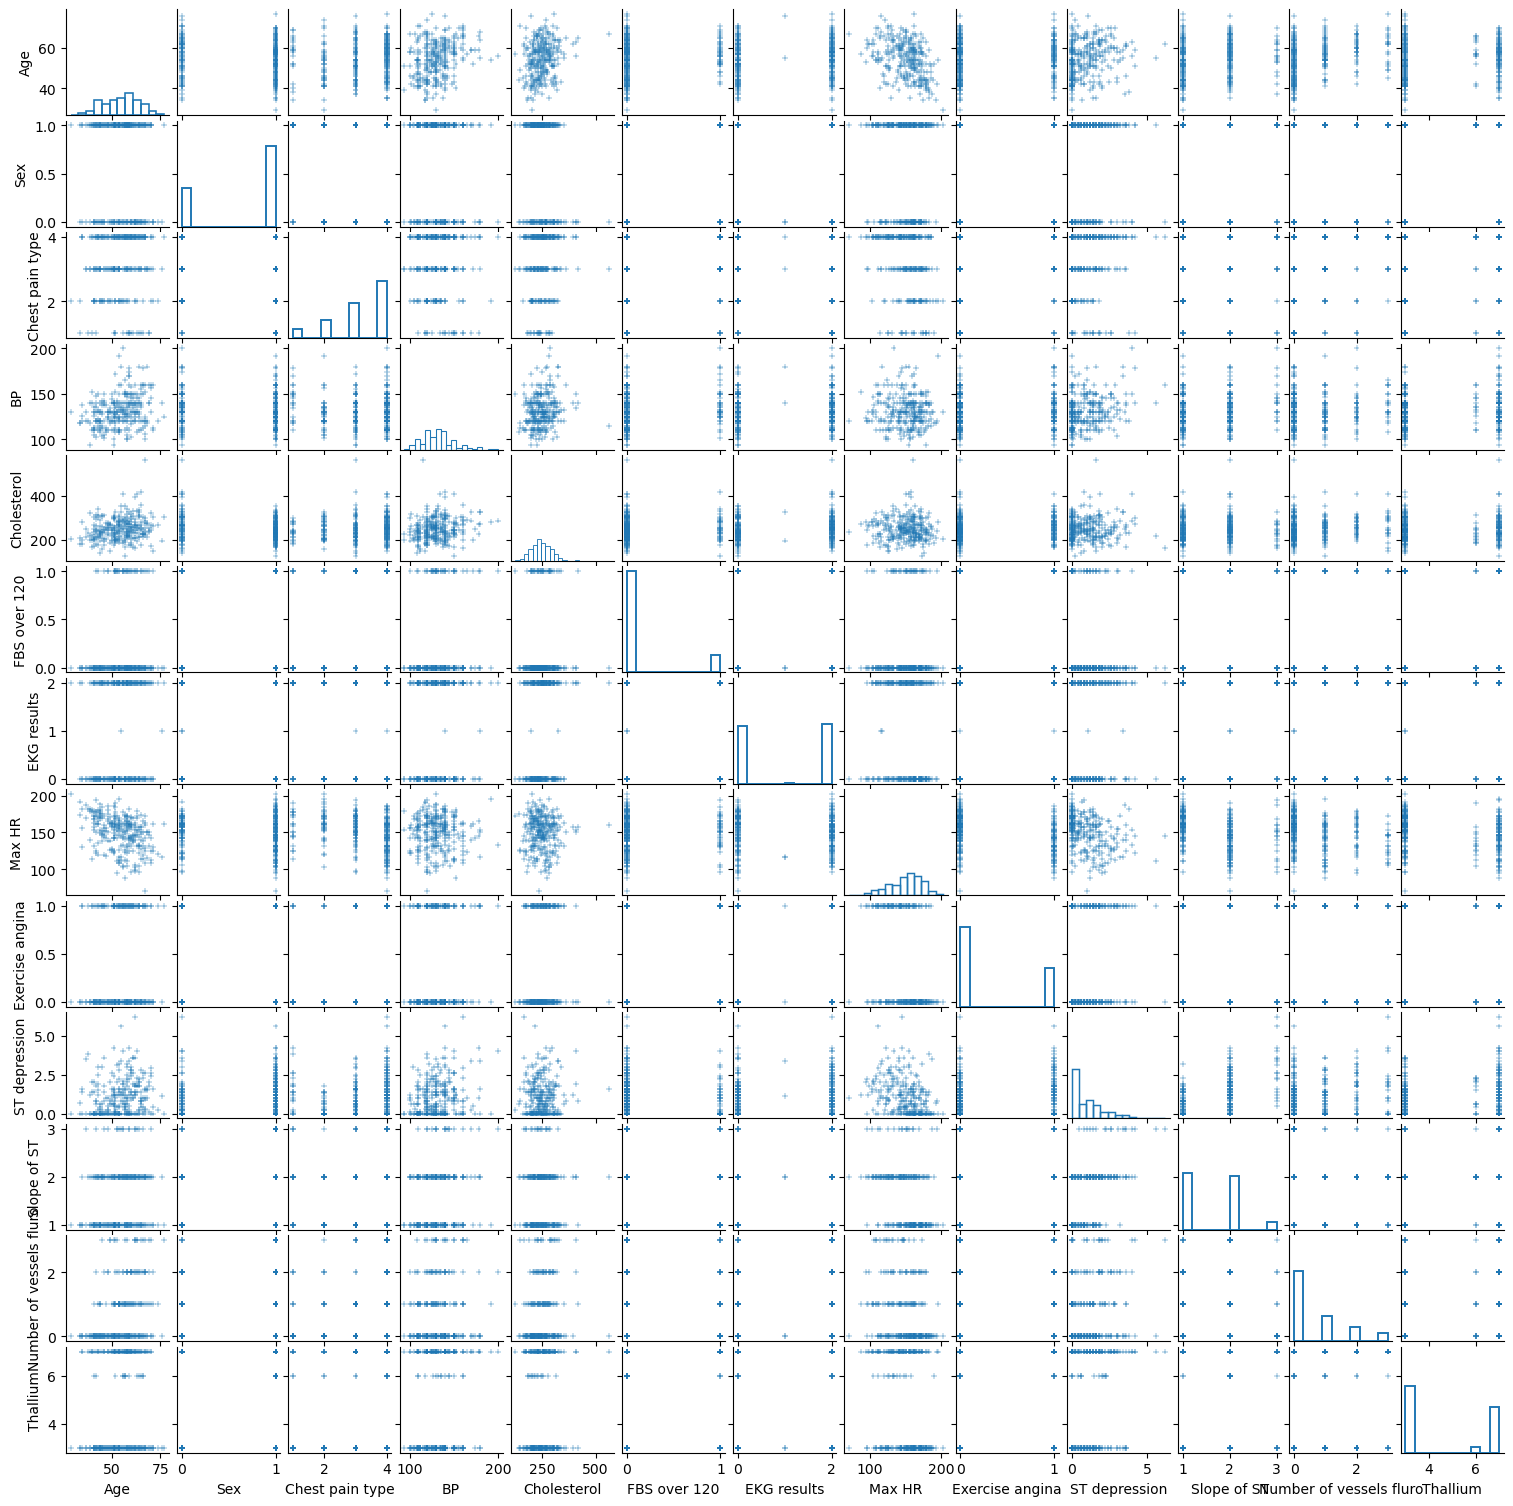

In [5]:
# pairplot
g = sns.pairplot(data=df,
                 plot_kws=dict(marker='+', size=3),
                 diag_kws=dict(fill=False))
g.fig.set_size_inches(15, 15)
plt.show()



/var/folders/3m/p_59xggd2q72lpkgh9mpp4j80000gn/T/ipykernel_30314/738939376.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation = df.corr()


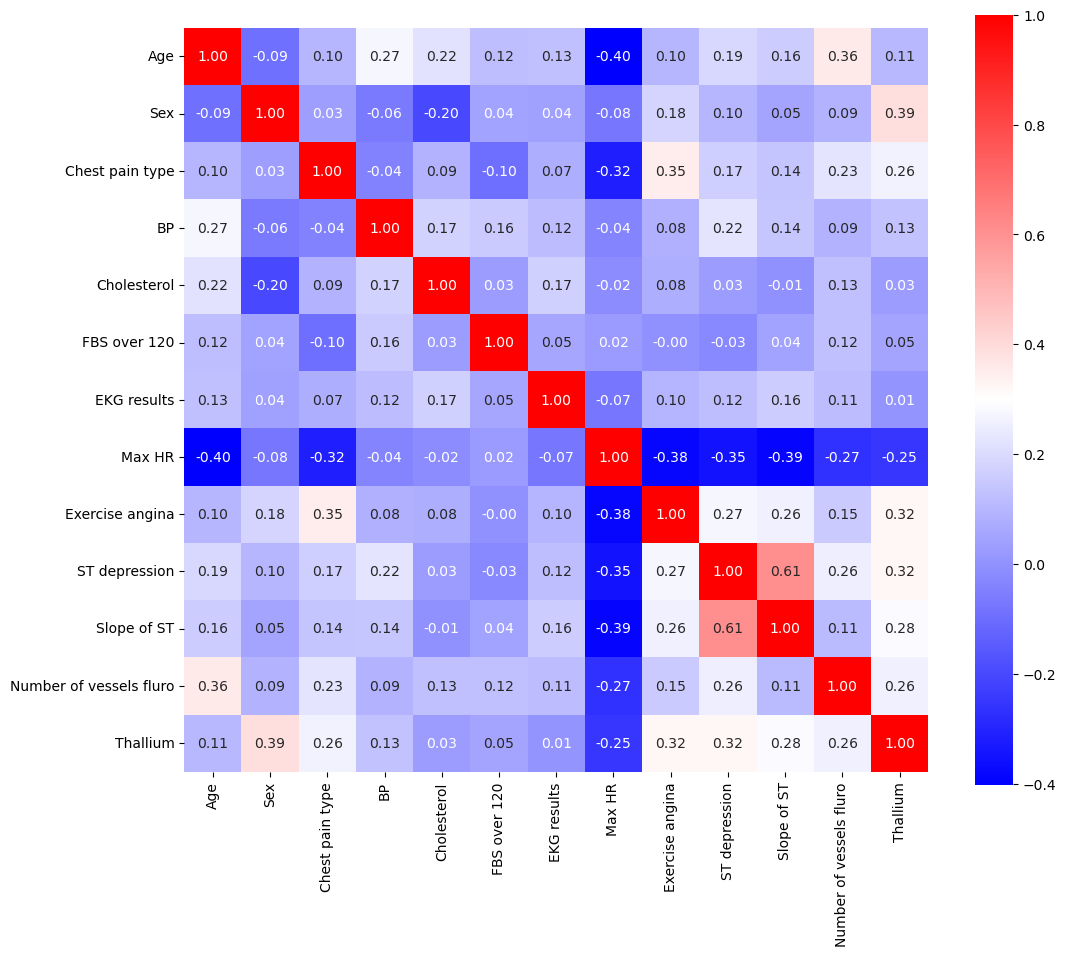

In [6]:
# correlation between variables
correlation = df.corr()

fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(correlation, cmap='bwr', cbar=True, fmt='.2f', annot=True, square=True,  ax=ax)
plt.show()

### Prepare the data for maschine learning

In [7]:
# prepare the data
X = df.drop(columns='Heart Disease')
y = df['Heart Disease'].map({'Presence':1, 'Absence':0})

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

numeric_variables = ['Age', 'BP', 'Cholesterol', 'Max HR', 'ST depression']
scaler = StandardScaler()
X_train[numeric_variables] = scaler.fit_transform(X_train[numeric_variables])
X_test[numeric_variables] = scaler.transform(X_test[numeric_variables])

### RandomForestClassifier

In [8]:
from sklearn.ensemble import RandomForestClassifier

In [9]:
# Prediction with RandomForestClassifier
rf = RandomForestClassifier(random_state=42)

rf.fit(X_train, y_train)
y_pred_rf0 = rf.predict(X_test)

print(f'The accuracy score for the RandomForestClassifier: {accuracy_score(y_test, y_pred_rf0):.4f}')
print('Classification report:')
print(classification_report(y_test, y_pred_rf0))



The accuracy score for the RandomForestClassifier: 0.7593
Classification report:
              precision    recall  f1-score   support

           0       0.78      0.85      0.81        33
           1       0.72      0.62      0.67        21

    accuracy                           0.76        54
   macro avg       0.75      0.73      0.74        54
weighted avg       0.76      0.76      0.76        54



In [10]:
# build a parameters grid
params_grid = {
    'n_estimators': np.arange(100, 501, 100).tolist(),
    'max_depth': np.arange(2, 9, 1).tolist(),
    'min_samples_split': np.arange(2, 8, 1).tolist(),
    'min_samples_leaf': [1, 2, 3, 4, 5],
    'max_features': ['sqrt', 'log2']
}

print(len(ParameterGrid(params_grid)))

2100


In [11]:
# RandomizedSearchCV
start = time.time()
random_search = RandomizedSearchCV(rf, params_grid, scoring='accuracy', cv=KFold(n_splits=5, shuffle=True, random_state=1))
random_search.fit(X_train, y_train)
end = time.time()
print(f'RandomizedSearchCV takes {(end-start):.4f} sec to tune')
random_search.best_estimator_


RandomizedSearchCV takes 7.2684 sec to tune


,n_estimators,100
,criterion,'gini'
,max_depth,6
,min_samples_split,7
,min_samples_leaf,5
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [12]:
rf_tuned1 = RandomForestClassifier(**random_search.best_params_)

rf_tuned1.fit(X_train, y_train)
y_pred_rf1 = rf_tuned1.predict(X_test)

print(f'The accuracy score for the RandomForestClassifier: {accuracy_score(y_test, y_pred_rf1):.4f}')
print('Classification report:')
print(classification_report(y_test, y_pred_rf1))

The accuracy score for the RandomForestClassifier: 0.9074
Classification report:
              precision    recall  f1-score   support

           0       0.87      1.00      0.93        33
           1       1.00      0.76      0.86        21

    accuracy                           0.91        54
   macro avg       0.93      0.88      0.90        54
weighted avg       0.92      0.91      0.90        54



In [13]:
# HalvingGridSearchCV
start = time.time()
halving_search = HalvingGridSearchCV(rf, params_grid, scoring='accuracy', cv=KFold(n_splits=5, shuffle=True, random_state=42))
halving_search.fit(X_train, y_train)
end = time.time()
print(f'HalvingGridSearchCV takes {(end-start):.4f} sec to tune')
halving_search.best_estimator_

HalvingGridSearchCV takes 1840.6893 sec to tune


,n_estimators,100
,criterion,'gini'
,max_depth,3
,min_samples_split,7
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [14]:
rf_tuned2 = RandomForestClassifier(**halving_search.best_params_)

rf_tuned2.fit(X_train, y_train)
y_pred_rf2 = rf_tuned2.predict(X_test)

print(f'The accuracy score for the RandomForestClassifier: {accuracy_score(y_test, y_pred_rf2):.4f}')
print('Classification report:')
print(classification_report(y_test, y_pred_rf2))

The accuracy score for the RandomForestClassifier: 0.8889
Classification report:
              precision    recall  f1-score   support

           0       0.85      1.00      0.92        33
           1       1.00      0.71      0.83        21

    accuracy                           0.89        54
   macro avg       0.92      0.86      0.88        54
weighted avg       0.91      0.89      0.88        54



In [15]:
# BayesSearchCV
start = time.time()
bayes_search = BayesSearchCV(rf, params_grid, scoring='accuracy', cv=KFold(n_splits=5, shuffle=True, random_state=42))
bayes_search.fit(X_train, y_train)
end = time.time()
print(f'BayesSearchCV takes {(end-start):.4f} sec to tune')
bayes_search.best_estimator_

BayesSearchCV takes 82.3915 sec to tune


,n_estimators,200
,criterion,'gini'
,max_depth,7
,min_samples_split,3
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'log2'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [16]:
rf_tuned3 = RandomForestClassifier(**bayes_search.best_params_)

rf_tuned3.fit(X_train, y_train)
y_pred_rf3 = rf_tuned3.predict(X_test)

print(f'The accuracy score for the RandomForestClassifier: {accuracy_score(y_test, y_pred_rf3):.4f}')
print('Classification report:')
print(classification_report(y_test, y_pred_rf3))

The accuracy score for the RandomForestClassifier: 0.8889
Classification report:
              precision    recall  f1-score   support

           0       0.89      0.94      0.91        33
           1       0.89      0.81      0.85        21

    accuracy                           0.89        54
   macro avg       0.89      0.87      0.88        54
weighted avg       0.89      0.89      0.89        54



### XGBoost

In [17]:
from xgboost import XGBClassifier

In [18]:
xgbc = XGBClassifier(
    objective='binary:hinge',
    eval_metric='logloss',
    n_estimators=300,
    early_stopping_rounds=20,
    seed=42
)

xgbc.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=False)
y_pred_xgbc0 = xgbc.predict(X_test)

print(f'The accuracy score for the XGBCassifier: {accuracy_score(y_test, y_pred_xgbc0):.4f}')
print('Classification report:')
print(classification_report(y_test, y_pred_xgbc0))

The accuracy score for the XGBCassifier: 0.7593
Classification report:
              precision    recall  f1-score   support

           0       0.83      0.76      0.79        33
           1       0.67      0.76      0.71        21

    accuracy                           0.76        54
   macro avg       0.75      0.76      0.75        54
weighted avg       0.77      0.76      0.76        54



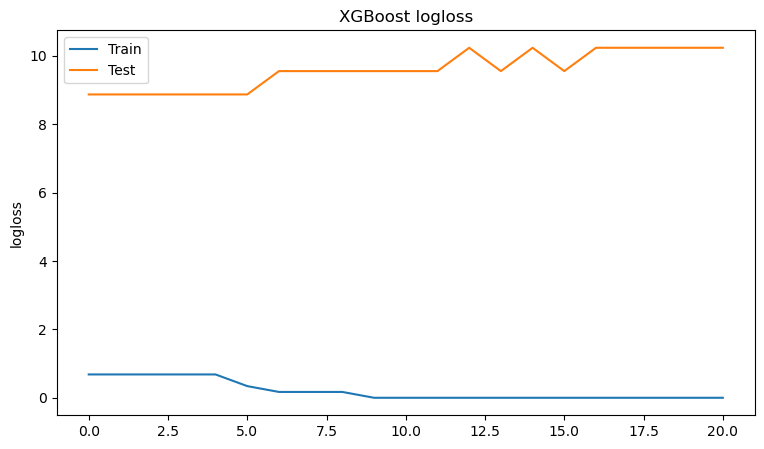

In [19]:
# preparing evaluation metric plots
results = xgbc.evals_result()
epochs = len(results['validation_0']['logloss'])
x_axis = range(0, epochs)

# xgboost 'mlogloss' plot
fig, ax = plt.subplots(figsize=(9,5))
ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
ax.plot(x_axis, results['validation_1']['logloss'], label='Test')
ax.legend()
plt.ylabel('logloss')
plt.title('XGBoost logloss')
plt.show()

In [20]:
params_grid_xgbc = {
    'learning_rate': np.arange(0.01, 0.5, 0.01).tolist(),
    'max_depth': np.arange(2, 9, 1).tolist(),
    'subsample': np.arange(0.5, 1.1, 0.1).tolist(),
    'colsample_bytree': np.arange(0.5, 1.1, 0.25).tolist(),
    'lambda': np.arange(1, 5, 1).tolist(),
    'alpha': np.arange(1, 5, 1).tolist()
}

print(len(ParameterGrid(params_grid_xgbc)))

115248


In [ ]:
# RandomizedSearchCV
start = time.time()
random_search_xgbc= RandomizedSearchCV(xgbc, params_grid_xgbc, scoring='accuracy', cv=KFold(n_splits=5, shuffle=True, random_state=1))
random_search_xgbc.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=False)
end = time.time()
print(f'RandomizedSearchCV takes {(end-start):.4f} sec to tune')
random_search_xgbc.best_estimator_

In [22]:
xgbc_tune1 = XGBClassifier(**random_search_xgbc.best_params_)

xgbc_tune1.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=False)
y_pred_xgbc1 = xgbc_tune1.predict(X_test)

print(f'The accuracy score for the XGBCassifier: {accuracy_score(y_test, y_pred_xgbc1):.4f}')
print('Classification report:')
print(classification_report(y_test, y_pred_xgbc1))

The accuracy score for the XGBCassifier: 0.8704
Classification report:
              precision    recall  f1-score   support

           0       0.84      0.97      0.90        33
           1       0.94      0.71      0.81        21

    accuracy                           0.87        54
   macro avg       0.89      0.84      0.86        54
weighted avg       0.88      0.87      0.87        54



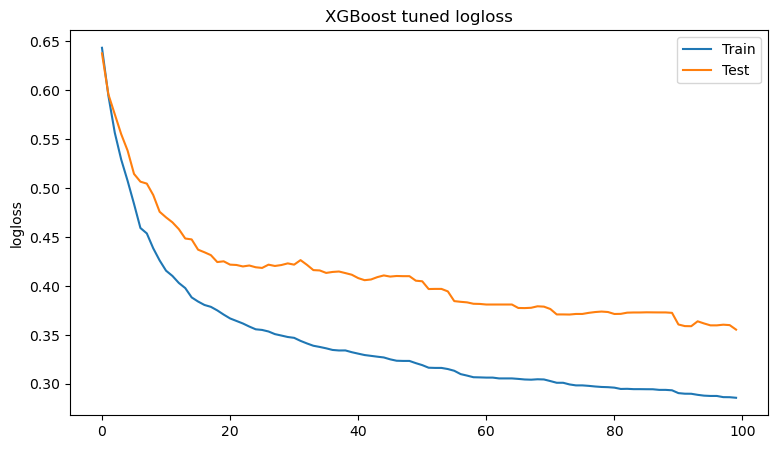

In [23]:
# preparing evaluation metric plots
results = xgbc_tune1.evals_result()
epochs = len(results['validation_0']['logloss'])
x_axis = range(0, epochs)

# xgboost 'mlogloss' plot
fig, ax = plt.subplots(figsize=(9,5))
ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
ax.plot(x_axis, results['validation_1']['logloss'], label='Test')
ax.legend()
plt.ylabel('logloss')
plt.title('XGBoost tuned logloss')
plt.show()

### Support Vector Classification

In [24]:
from sklearn.svm import SVC

In [25]:
svm = SVC(kernel='linear', C=1, random_state=42)
svm.fit(X_train, y_train)

y_pred_svc0 = svm.predict(X_test)
print(f'The accuracy score for Support Vector Classifier is {accuracy_score(y_test, y_pred_svc0):.4f}')
print('Classification report')
print(classification_report(y_test, y_pred_svc0))

The accuracy score for Support Vector Classifier is 0.8704
Classification report
              precision    recall  f1-score   support

           0       0.86      0.94      0.90        33
           1       0.89      0.76      0.82        21

    accuracy                           0.87        54
   macro avg       0.88      0.85      0.86        54
weighted avg       0.87      0.87      0.87        54



In [26]:
# hyperparameter tuning

params_grid_svc = [
    {'C': np.logspace(-1, 3, 5), 'kernel': ['linear']},
    {'C': np.logspace(-1, 3, 5), 'kernel': ['poly'], 'degree': [2, 3, 4, 5, 6], 'gamma': np.logspace(-3, -1, 3)},
    {'C': np.logspace(-1, 3, 5), 'kernel': ['rbf'], 'gamma': np.logspace(-3, 1, 5)},
    {'C': np.logspace(-1, 3, 5), 'kernel': ['sigmoid'], 'gamma': np.logspace(-4, -1, 4)}
]

start = time.time()
grid_search_svc = GridSearchCV(svm, params_grid_svc, scoring='accuracy', cv=KFold(n_splits=5, shuffle=True, random_state=42))
grid_search_svc.fit(X_train, y_train)
end = time.time()
print(f'Support vector classifier takes {(end-start):.4f} sec to tune')
grid_search_svc.best_estimator_

Support vector classifier takes 2.7139 sec to tune


,C,100.0
,kernel,'rbf'
,degree,3
,gamma,0.001
,coef0,0.0
,shrinking,True
,probability,False
,tol,0.001
,cache_size,200
,class_weight,None
,verbose,False


In [27]:
svm_tuned1 = SVC(**grid_search_svc.best_params_)

svm_tuned1.fit(X_train, y_train)
y_pred_svc1 = svm_tuned1.predict(X_test)
print(f'The accuracy score for Support Vector Classifier is {accuracy_score(y_test, y_pred_svc1):.4f}')
print('Classification report')
print(classification_report(y_test, y_pred_svc1))

The accuracy score for Support Vector Classifier is 0.9074
Classification report
              precision    recall  f1-score   support

           0       0.87      1.00      0.93        33
           1       1.00      0.76      0.86        21

    accuracy                           0.91        54
   macro avg       0.93      0.88      0.90        54
weighted avg       0.92      0.91      0.90        54



### Logistic Regression

In [28]:
from sklearn.linear_model import LogisticRegression

In [29]:
lg = LogisticRegression(random_state=42, max_iter=1000)

lg.fit(X_train, y_train)
y_pred_lg0 = lg.predict(X_test)

print(f'The accuracy score for logistic regression is {accuracy_score(y_test, y_pred_lg0):.4f}')
print('Classification report')
print(classification_report(y_test, y_pred_lg0))

The accuracy score for logistic regression is 0.9074
Classification report
              precision    recall  f1-score   support

           0       0.91      0.94      0.93        33
           1       0.90      0.86      0.88        21

    accuracy                           0.91        54
   macro avg       0.91      0.90      0.90        54
weighted avg       0.91      0.91      0.91        54



In [30]:
# optimization of hyperparameters
params_grid_lg = [
    {'penalty': ['l2', None]},
    {'penalty': ['l2'], 'C': np.logspace(-3, 3, 7)},
    {'penalty': ['l1', 'l2'], 'C': np.logspace(-3, 3, 7), 'solver': ['liblinear', 'saga']}
]

grid_search_lg = GridSearchCV(lg, params_grid_lg, scoring='accuracy', cv=KFold(n_splits=5, shuffle=True, random_state=6))
grid_search_lg.fit(X_train, y_train)

grid_search_lg.best_estimator_

,penalty,'l1'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,42
,solver,'liblinear'
,max_iter,1000
,multi_class,'deprecated'


In [31]:
lg_tune1 = LogisticRegression(**grid_search_lg.best_params_)

lg_tune1.fit(X_train, y_train)
y_pred_lg1 = lg_tune1.predict(X_test)

print(f'The accuracy score for the tuned logistic regression is {accuracy_score(y_test, y_pred_lg1):.4f}')
print('Classification report')
print(classification_report(y_test, y_pred_lg1))

The accuracy score for the tuned logistic regression is 0.9259
Classification report
              precision    recall  f1-score   support

           0       0.91      0.97      0.94        33
           1       0.95      0.86      0.90        21

    accuracy                           0.93        54
   macro avg       0.93      0.91      0.92        54
weighted avg       0.93      0.93      0.93        54



### AdaBoostClassifier

In [32]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

In [33]:
abc = AdaBoostClassifier(random_state=42)

abc.fit(X_train, y_train)
y_pred_abc0 = abc.predict(X_test)

print(f'The accuracy score for the base AdaBoostClassifier is {accuracy_score(y_test, y_pred_abc0):.4f}')
print('Classification report')
print(classification_report(y_test, y_pred_abc0))

The accuracy score for the base AdaBoostClassifier is 0.8704
Classification report
              precision    recall  f1-score   support

           0       0.86      0.94      0.90        33
           1       0.89      0.76      0.82        21

    accuracy                           0.87        54
   macro avg       0.88      0.85      0.86        54
weighted avg       0.87      0.87      0.87        54



In [34]:
# tune the AdaBoostClassifier
tree1 = DecisionTreeClassifier(max_depth=1, random_state=42)
tree2 = DecisionTreeClassifier(max_depth=2, random_state=42)
tree3 = DecisionTreeClassifier(max_depth=3, random_state=42)
tree4 = DecisionTreeClassifier(max_depth=4, random_state=42)

params_grid_abc = {
    'estimator': [tree1, tree2, tree3, tree4, lg],
    'learning_rate': [0.1, 0.5, 1],
    'n_estimators': np.arange(50, 105, 10).tolist()
}

grid_search_abc = GridSearchCV(abc, params_grid_abc, scoring='accuracy', cv=KFold(n_splits=5, shuffle=True, random_state=42))
grid_search_abc.fit(X_train, y_train)
grid_search_abc.best_estimator_

,estimator,DecisionTreeC...ndom_state=42)
,n_estimators,70
,learning_rate,0.5
,algorithm,'deprecated'
,random_state,42
,criterion,'gini'
,splitter,'best'
,max_depth,1
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0


In [35]:
abc_tuned1 = AdaBoostClassifier(**grid_search_abc.best_params_)

abc_tuned1.fit(X_train, y_train)
y_pred_abc1 = abc_tuned1.predict(X_test)

print(f'The accuracy score for the tuned AdaBoostClassifier is {accuracy_score(y_test, y_pred_abc1):.4f}')
print('Classification report')
print(classification_report(y_test, y_pred_abc1))

The accuracy score for the tuned AdaBoostClassifier is 0.8704
Classification report
              precision    recall  f1-score   support

           0       0.86      0.94      0.90        33
           1       0.89      0.76      0.82        21

    accuracy                           0.87        54
   macro avg       0.88      0.85      0.86        54
weighted avg       0.87      0.87      0.87        54

